# Тестирование двух платёжных воронок

**Техническое задание**
* Название теста: recommender_system_test;
* Группы: А (контрольная), B (новая платёжная воронка);
* Дата запуска: 2020-12-07;
* Дата остановки набора новых пользователей: 2020-12-21;
* Дата остановки: 2021-01-04;
* Аудитория: 15% новых пользователей из региона EU;
* Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* Ожидаемое количество участников теста: 6000.
* Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
 - конверсии в просмотр карточек товаров — событие product_page
 - просмотры корзины — product_cart
 - покупки — purchase.

**План.**
1. [Описать цели исследования.](#section_id_1)
2. [Исследовать данные.](#section_id_2)
* Изучить данные.
* Преобразовать некоторые типы данных.
* Провести проверку на пропущенные значения.
* Провести проверку на дубликаты.
3. [Провести оценка корректности данных.](#section_id_3)
* Проверить временные данные на соответствие условиям проекта.
* Проверить корректность поля details.
* Определить количество групп в нашем тесте.
* Определить дату начала и окончания регистрации.
* Отфилльтровать данные теста по типу теста recommender_system_test.
* Проверить на условие, что 15% новых пользователей из региона EU.
* Определить сколько пользователей в каждой группе.
* Объеденить данные в одну таблицу.
* Проверить ожидаемое количество участников теста.
* Поставить ограничение на лайфтайм клиента - 14 дней.
* Проверить нет в тесте пользователей, учавствовавших в обоих группах одновременно.
* Определим сколько пользователей в каждой группе
4. [Провести исследовательский анализ данных. Ответить на вопросы:](#section_id_4)
* Количество событий на пользователя одинаково распределены в выборках?
* Как число событий в выборках распределено по дням?
* Время проведения теста не совпадает с маркетинговыми и другими активностями?
* Как меняется конверсия в воронке в выборках на разных этапах?
* Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?
5. [Провести A/B-тестирование.](#section_id_5)
* Создать таблицу, которая покажет конверсию.
* Создать сводную таблицу для теста.
* Сформулировать гипотезы и провести тесты.
* Проверка уровня статистической значимости
6. [Вывод.](#section_id_6)

**Описание данных.** <br>

**Данные:**
* `ab_project_marketing_events.csv`<br>
* `final_ab_new_users.csv`<br>
* `final_ab_events.csv`<br>
* `final_ab_participants.csv`<br>


**`ab_project_marketing_events.csv`** — календарь маркетинговых событий на 2020 год;<br>
* `name` — название маркетингового события;
* `regions` — регионы, в которых будет проводиться рекламная кампания;
* `start_dt` — дата начала кампании;
* `finish_dt` — дата завершения кампании.


**`final_ab_new_users.csv`** — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;
* `user_id` — идентификатор пользователя;
* `first_date` — дата регистрации;
* `region` — регион пользователя;
* `device` — устройство, с которого происходила регистрация.


**`final_ab_events.csv`** — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;
* `user_id` — идентификатор пользователя;
* `event_dt` — дата и время события;
* `event_name` — тип события;
* `details` — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.


**`final_ab_participants.csv`** — таблица участников тестов.<br>
* `user_id` — идентификатор пользователя;
* `ab_test` — название теста;
* `group` — группа пользователя

## 1. Описание целей исследования.<a id='section_id_1'></a>

В нашем распоряжении датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов. Наша задача — провести оценку результатов A/B-теста.<br>
* <u>Назначение теста:</u> тестирование изменений, связанных с внедрением улучшенной рекомендательной системы.<br>
* <u>Ожидаемый эффект:</u> за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:<br>
   * конверсии в просмотр карточек товаров — событие `product_page`<br>
   * просмотры корзины — `product_cart`<br>
   * покупки — `purchase`<br>

## 2. Исследование данных.<a id='section_id_2'></a>

* **Изучим данные**

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import math as mth
import numpy as np
from scipy import stats as st
import plotly.express as px
from plotly import graph_objects as go

In [2]:
try:
    marketing, new_users, events, participants = (
    pd.read_csv('ab_project_marketing_events.csv'),
    pd.read_csv('final_ab_new_users.csv'), 
    pd.read_csv('final_ab_events.csv'),
    pd.read_csv('final_ab_participants.csv')
)
except: FilePathError

In [3]:
marketing.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [5]:
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [7]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [8]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [9]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [10]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


* **Преобразуем некоторые типы данных**

In [11]:
marketing['start_dt'] = pd.to_datetime(marketing['start_dt']) 
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt']) 
new_users['first_date'] = pd.to_datetime(new_users['first_date']) 
events['event_dt'] = pd.to_datetime(events['event_dt'])

* **Проверка на пропущенные значения**

In [12]:
pass_list = [marketing, new_users, events, participants]
for index in pass_list:
    print(index.isna().sum())

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
user_id       0
first_date    0
region        0
device        0
dtype: int64
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64
user_id    0
group      0
ab_test    0
dtype: int64


In [13]:
len(events[events['event_name'] != 'purchase'])

377577

Пропуски найдены в одном поле, `details` датафрейма `events`, которое несёт информацию о дополнительных данных о событии. В нашем случае оно несёт информацию о стоимости покупки в долларах события `purchase`, а в остальных данных пропущенное значение.

* **Проверка на дубликаты**

In [14]:
duplicate_list = [marketing, new_users, events, participants]
for index in duplicate_list:
    print(index.duplicated().sum())

0
0
0
0


## 3. Оценка корректности данных.<a id='section_id_3'></a>

* **Проверим временные данные на соответствие условиям проекта**

In [15]:
len(marketing[marketing['start_dt'] > marketing['finish_dt']])

0

* **Проверим корректность поля `details`**

In [16]:
print(events['details'].unique())
print(events[events['details'] < 0])

[ 99.99   9.99   4.99 499.99    nan]
Empty DataFrame
Columns: [user_id, event_dt, event_name, details]
Index: []


* **Определим количество групп в нашем тесте**

In [17]:
participants['group'].unique()

array(['A', 'B'], dtype=object)

Перед нами парный тест

* **Определим дату начала и окончания регистрации**

In [18]:
print('Минимальная дата регистрации', new_users['first_date'].min())
print('Максимальная дата регистрации', new_users['first_date'].max())
print('Минимальная дата события', events['event_dt'].min())
print('Максимальная дата события', events['event_dt'].max())

Минимальная дата регистрации 2020-12-07 00:00:00
Максимальная дата регистрации 2020-12-23 00:00:00
Минимальная дата события 2020-12-07 00:00:33
Максимальная дата события 2020-12-30 23:36:33


По ТЗ дата остановки набора новых пользователей - `2020-12-21`, значит начиная с `2020-12-22` набор новых пользователей прекращается.

In [19]:
new_users = new_users.query('first_date < "2020-12-22 00:00:00"')
new_users['first_date'].max()

Timestamp('2020-12-21 00:00:00')

Дата остановки набора новых пользователей: 2020-12-21. Мы рассматриваем события, которые совершены в течение 14 дней с момента регистрации.

* **Проверим пункт ТЗ: аудитория: 15% новых пользователей из региона EU.**

In [20]:
table_user_partic = new_users.merge(participants.query('ab_test == "recommender_system_test"'), on='user_id')
table_region = table_user_partic.groupby('region').agg({'user_id':'nunique'}).reset_index()
table_region['%_EU'] = round(table_region['user_id']/table_region['user_id'].sum(),4)*100
table_region

,region,user_id,%_EU
0,APAC,72,1.07
1,CIS,55,0.82
2,EU,6351,94.78
3,N.America,223,3.33


In [21]:
len(table_user_partic.query('region == "EU"'))/len(new_users.query('region == "EU"'))*100

15.0

* **Проверим данные на наличие пользователей, которые учавствуют в нескольких тестах одновременно.**

Нам важно проверить попали ли пользователи нашего теста в экспериментальную группу конкурирующего теста. Если такие пользователи имеются, то будет сложно оценить какое из нововведений повлияло на действие пользователя (наше recommender_system_test или 	interface_eu_test), поэтому их следует удалить.

In [22]:
table_system_test = participants.query('ab_test == "recommender_system_test"')
table_eu_test = participants.query('ab_test == "interface_eu_test" and group == "B"')
table_cross = table_system_test.merge(table_eu_test, on='user_id')
table_cross = table_cross.drop('group_x', axis=1)
table_cross.shape[0]

783

In [23]:
participants = participants[-participants['user_id'].isin(table_cross['user_id'])]

* **Оставим данные теста `recommender_system_test`**

In [24]:
participants = participants.query('ab_test == "recommender_system_test"')

* **Определим сколько пользователей в каждой группе**

In [25]:
print('Количество пользователей группы А:', participants[participants['group'] == 'A']['user_id'].nunique())
print('Количество пользователей группы B:', participants[participants['group'] == 'B']['user_id'].nunique())

Количество пользователей группы А: 3385
Количество пользователей группы B: 2533


Наборы пользователей в группах различаются ~ на 25%. Это достаточно много. Группы не назвать сбалансированными. Но это не окончательное количество человек в группах. Предстоит подвергнуть данным некоторым условиям.

* **Объеденим данные в одну таблицу**

In [26]:
general_table = participants.merge(new_users, on='user_id', how='left')
general_table = general_table.merge(events, on='user_id', how='outer')
general_table.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN


* **Проверим ожидаемое количество участников теста**

In [27]:
general_table['user_id'].nunique()

61377

* **Поставим ограничение на лайфтайм клиента - 14 дней**

In [28]:
general_table['life_time'] = general_table['event_dt'] - general_table['first_date']
general_table['life_time'] = general_table['life_time'].dt.days
general_table = general_table.query('life_time <= 14')
general_table.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,life_time
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,0.0
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,0.0
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,0.0
6,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,NaN,0.0
8,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,NaN,0.0


In [29]:
print('Количество участников снизилось до', general_table['user_id'].nunique())

Количество участников снизилось до 3244


* **Проверим нет в тесте пользователей, учавствовавших в обоих группах одновременно**

In [30]:
table_A = general_table[general_table['group'] == 'A']
table_B = general_table[general_table['group'] == 'B']
table_visitors = table_A.merge(table_B, on='user_id', how='inner')
table_visitors['user_id'].nunique()

0

* **Определим сколько пользователей в каждой группе**

In [31]:
print('Количество пользователей группы А:', general_table[general_table['group'] == 'A']['user_id'].nunique())
print('Количество пользователей группы B:', general_table[general_table['group'] == 'B']['user_id'].nunique())

Количество пользователей группы А: 2422
Количество пользователей группы B: 822


По лайфтайму группы перешли в сильный дисбаланс. Размер группы А ~ в 3 раза больше группы В. Необходимо это учитывать в дальнейшем.

## 4. Исследовательский анализ данных.<a id='section_id_4'></a>

* **Количество событий на пользователя одинаково распределены в выборках?**

In [32]:
round(len(general_table[general_table['group'] == 'A']['event_dt'])/\
general_table[general_table['group'] == 'A']['user_id'].nunique(),3)

6.945

In [33]:
round(len(general_table[general_table['group'] == 'B']['event_dt'])/\
general_table[general_table['group'] == 'B']['user_id'].nunique(),3)

5.42

Пользователи контрольной группы отмечают большую активность, чем в тестовой группе.

* **Как число событий в выборках распределено по дням?**

In [34]:
warnings.filterwarnings('ignore')
general_table_A = general_table.query('group == "A"')
general_table_A['event_dt'] = general_table_A['event_dt'].dt.strftime('%Y-%m-%d')
general_table_A = general_table_A.groupby('event_dt').agg({'event_name':'count'}).reset_index()
general_table_A.head()

,event_dt,event_name
0,2020-12-07,276
1,2020-12-08,311
2,2020-12-09,345
3,2020-12-10,313
4,2020-12-11,327


In [35]:
general_table_B = general_table.query('group == "B"')
general_table_B['event_dt'] = general_table_B['event_dt'].dt.strftime('%Y-%m-%d')
general_table_B = general_table_B.groupby('event_dt').agg({'event_name':'count'}).reset_index()
general_table_B.head()

,event_dt,event_name
0,2020-12-07,337
1,2020-12-08,221
2,2020-12-09,312
3,2020-12-10,232
4,2020-12-11,144


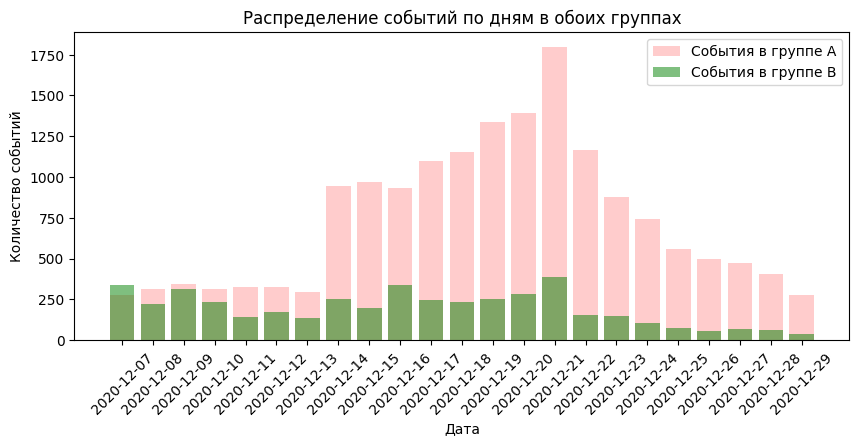

In [36]:
plt.figure(figsize=(10, 4))
plt.bar(general_table_A['event_dt'], general_table_A['event_name'], 
         color='r', alpha=0.2, label='События в группе А')
plt.bar(general_table_B['event_dt'], general_table_B['event_name'], 
         color='g', alpha=0.5, label='События в группе В')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Распределение событий по дням в обоих группах')
plt.legend()
plt.xticks(rotation=45)
plt.show();

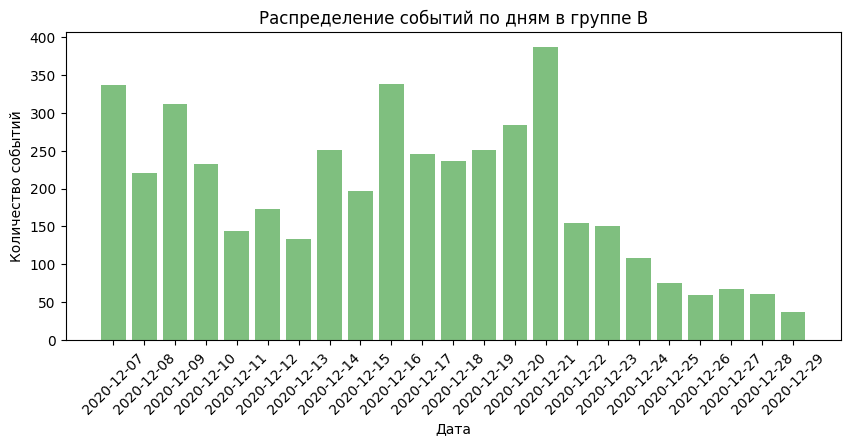

In [37]:
plt.figure(figsize=(10, 4))
plt.bar(general_table_B['event_dt'], general_table_B['event_name'], 
         color='g', alpha=0.5)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Распределение событий по дням в группе В')
plt.xticks(rotation=45)
plt.show();

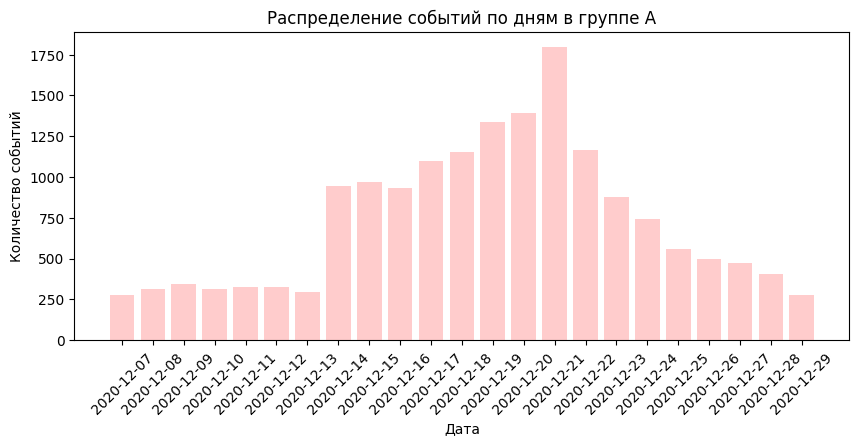

In [38]:
plt.figure(figsize=(10, 4))
plt.bar(general_table_A['event_dt'], general_table_A['event_name'], 
         color='r', alpha=0.2)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Распределение событий по дням в группе А')
plt.xticks(rotation=45)
plt.show();

На первом графике можно увидеть насколько меньше событий в тестовой группе. Распределения групп нельзя назвать похожими. Только 21 декабря наблюдается резкий всплеск в обоих группах. Так же можно заметить, что в тестовой группе всплески имеются 7, 9, и 16 декабря. Обе группы к концу теста снижают свою активность.

Посмотри как распределён набор новых пользователей по дням.

In [39]:
general_table['first_date'] = general_table['first_date'].dt.strftime('%Y-%m-%d')

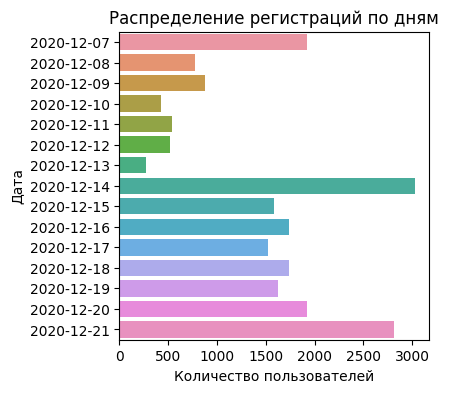

In [40]:
plt.figure(figsize=(4, 4))
sns.countplot(y='first_date', data=general_table.sort_values(by='first_date'))
plt.xlabel('Количество пользователей')
plt.ylabel('Дата')
plt.title('Распределение регистраций по дням');

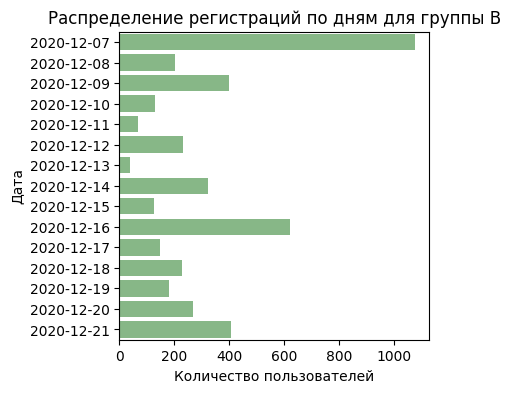

In [41]:
plt.figure(figsize=(4, 4))
sns.countplot(y='first_date', data=general_table.query('group == "B"').sort_values(by='first_date'), 
              color='g', alpha=0.5)
plt.xlabel('Количество пользователей')
plt.ylabel('Дата')
plt.title('Распределение регистраций по дням для группы В');

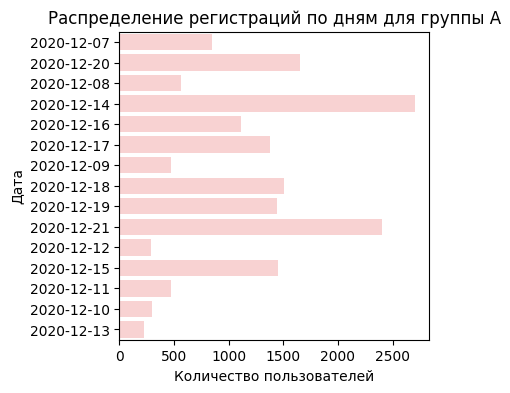

In [42]:
plt.figure(figsize=(4, 4))
sns.countplot(y='first_date', data=general_table.query('group == "A"'), color='r', alpha=0.2)
plt.xlabel('Количество пользователей')
plt.ylabel('Дата')
plt.title('Распределение регистраций по дням для группы A');

Пики набора группы В -  7, 9 16 и 21 декабря. Пики активности группы В приходятся на те же даты: 7, 9, 16 и 21 декабря. <br>
Пики в наборе группы А -  14 и 21 декабря. Пики активности группы А - 21 декабря резкий скачок. 

* **Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями**

In [43]:
marketing[marketing['regions'].str.contains("EU")].sort_values(by='start_dt')

,name,regions,start_dt,finish_dt
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


На пересечение наших дат попадает  маркетинговое событие Christmas&New Year Promo. Но оно приходится на окончание нашего тестирование, где активность клиентов значительно падает.

* **Как меняется конверсия в воронке в выборках на разных этапах?**

In [44]:
table_event_A = pd.pivot_table(general_table.query('group == "A"'),
               index='event_name',
               values='user_id',
               aggfunc='nunique').reset_index()
table_event_A = table_event_A.sort_values(by='user_id', ascending=False)
table_event_A['conversion'] = 100
for i in range(0, len(table_event_A['user_id'])):
    if i != 0:
        table_event_A['conversion'].iloc[i] = \
        round(table_event_A['user_id'].iloc[i]/table_event_A['user_id'].iloc[i-1]*100)
table_event_A

,event_name,user_id,conversion
0,login,2422,100
2,product_page,1571,65
3,purchase,773,49
1,product_cart,728,94


In [45]:
table_event_B = pd.pivot_table(general_table.query('group == "B"'),
               index='event_name',
               values='user_id',
               aggfunc='nunique').reset_index()
table_event_B = table_event_B.sort_values(by='user_id', ascending=False)
table_event_B['conversion'] = 100
for i in range(0, len(table_event_B['user_id'])):
    if i != 0:
        table_event_B['conversion'].iloc[i] = \
        round(table_event_B['user_id'].iloc[i]/table_event_B['user_id'].iloc[i-1]*100)
table_event_B

,event_name,user_id,conversion
0,login,821,100
2,product_page,459,56
3,purchase,226,49
1,product_cart,225,100


In [46]:
table_event_conv = table_event_A.merge(table_event_B, on='event_name')
table_event_conv['conv_diff'] = table_event_conv['conversion_y'] - table_event_conv['conversion_x']
table_event_conv

,event_name,user_id_x,conversion_x,user_id_y,conversion_y,conv_diff
0,login,2422,100,821,100,0
1,product_page,1571,65,459,56,-9
2,purchase,773,49,226,49,0
3,product_cart,728,94,225,100,6


Воронка получилась некорректная. Видимо можно пропустить этап корзины и сразу совершить покупку. Конверсия перехода на старницу товара уменьшилась на 9% в тестовой группе. Конвесия покупки не изменилась. Смотреть конверсию корзины товара не релевантно.
В силу некоректности воронки рассмотрим конверсию по отношению к авторизации пользователя.

* **Создадим таблицу, которая покажет конверсию каждой метрики по отношению к событию login**

In [47]:
table_event_A_new = pd.pivot_table(general_table.query('group == "A"'),
               index='event_name',
               values='user_id',
               aggfunc='nunique').reset_index()
table_event_A_new = table_event_A_new.sort_values(by='user_id', ascending=False)
table_event_A_new['conversion'] = 100
for i in range(0, len(table_event_A['user_id'])):
    if i != 0:
        table_event_A_new['conversion'].iloc[i] = \
        round(table_event_A_new['user_id'].iloc[i]/table_event_A_new['user_id'].iloc[0]*100)
table_event_A_new

,event_name,user_id,conversion
0,login,2422,100
2,product_page,1571,65
3,purchase,773,32
1,product_cart,728,30


In [48]:
table_event_B_new = pd.pivot_table(general_table.query('group == "B"'),
               index='event_name',
               values='user_id',
               aggfunc='nunique').reset_index()
table_event_B_new = table_event_B_new.sort_values(by='user_id', ascending=False)
table_event_B_new['conversion'] = 100
for i in range(0, len(table_event_B['user_id'])):
    if i != 0:
        table_event_B_new['conversion'].iloc[i] = \
        round(table_event_B_new['user_id'].iloc[i]/table_event_B_new['user_id'].iloc[0]*100)
table_event_B_new

,event_name,user_id,conversion
0,login,821,100
2,product_page,459,56
3,purchase,226,28
1,product_cart,225,27


Конверсия к шагу login

In [49]:
table_event_conv_new = table_event_A_new.merge(table_event_B_new, on='event_name')
table_event_conv_new['conv_diff'] = table_event_conv_new['conversion_y'] - table_event_conv_new['conversion_x']
table_event_conv_new

,event_name,user_id_x,conversion_x,user_id_y,conversion_y,conv_diff
0,login,2422,100,821,100,0
1,product_page,1571,65,459,56,-9
2,purchase,773,32,226,28,-4
3,product_cart,728,30,225,27,-3


Конверсия упала на каждом шаге.

In [ ]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'группа А',
    orientation = "h",
    y = ["login", "product_page", "product_cart", "purchase"],
    x = [2422, 1571, 728, 773],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'группа В',
    orientation = "h",
    y = ["login", "product_page", "product_cart", "purchase"],
    x = [821, 459, 225, 226],
    textposition = "outside",
    textinfo = "value+percent initial"))

fig.show();

[![newplot-3.png](https://i.postimg.cc/7YDX9mTL/newplot-3.png)](https://postimg.cc/Yjn1qNRc)

* **Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?**

Наши данные не являются идеально подходящими под ТЗ. Реальное количество участников теста почти на 46% меньше ожидаемого. Группы не сбалансированы, контрольная в 3 раза больше тестовой. Группы неравномерно активные. Воронка не соответствует логическим шагам. Пропуск этапа корзины товара затрудняет адекватную оценку данной метрики. Данные трудности стоит учитывать при проведении теста и формулировании результата.

## 5. A/B-тестирование.<a id='section_id_5'></a>

* **Создадим сводную таблицу для теста.**

In [50]:
table_group = general_table.pivot_table(
            index='event_name',
            columns='group',
            values='user_id',
            aggfunc='nunique').sort_values(by='A', ascending=False)
table_group

group,A,B
event_name,,
login,2422,821
product_page,1571,459
purchase,773,226
product_cart,728,225


* **Сформулируем гипотезы и проведём 3 теста.**

Н<sub>0</sub>: Доли посетителей на каждом этапе воронки по отношению к действию авторизации для каждой группы одинаковы<br>

Н<sub>a</sub>: Доли посетителей на каждом этапе воронки по отношению к действию авторизации для каждой группы различны.

Введём функцию подсчёта статистики.

In [51]:
unique_A = table_group.loc['login', 'A']
unique_B = table_group.loc['login', 'B']
alpha = 0.01

def p_test(successes_1, successes_2, trials_1, trials_2):
    # пропорция успехов в каждой группе:
    p1 = successes_1 / trials_1
    p2 = successes_2 / trials_2
    
    # пропорция успехов в комбинированном датасете:
    p = (successes_1 + successes_2) / (trials_1 + trials_2)
    
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p * (1 - p) * (1/trials_1 + 1/trials_2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными'
        ) 

Зададим цикл, который посчитает для групп статистическое отличие для каждого события.

In [52]:
for event in table_group.index:
    if event != 'login':
        p_test(table_group.loc[event, 'A'], table_group.loc[event, 'B'], unique_A, unique_B)
        print()

p-значение:  4.575797608152854e-06
Отвергаем нулевую гипотезу: между группами есть значимая разница

p-значение:  0.01859038755136444
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

p-значение:  0.14938759297956405
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



* **Проверка уровня статистической значимости.**

Критический уровень статистической значимости был выбран 0.01. В нашем исследовании было проведено 3 теста. При множественных тестах увеличивается вероятность получить ошибку ложнопозитивного результата. Применим поправку Бонферрони и повторим тесты.

In [53]:
alpha = alpha/3

In [54]:
for event in table_group.index:
    if event != 'login':
        p_test(table_group.loc[event, 'A'], table_group.loc[event, 'B'], unique_A, unique_B)
        print()

p-значение:  4.575797608152854e-06
Отвергаем нулевую гипотезу: между группами есть значимая разница

p-значение:  0.01859038755136444
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

p-значение:  0.14938759297956405
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



Результаты теста после применения поправки не изменились.

## 6. Вывод.<a id='section_id_6'></a>

1. Группы имеют значительный дисбаланс. Контрольная группа втрое больше тестовой. Пользователи тестовой группы отмечают меньше активность - количество действий на пользователя в тестовой группе 5,4, тогда как в контрольной группе 6,9.
2. Количество участников теста 3.244 вместо 6.000 ожидаемых.
3. Количество событий в тестовой группе сильно уступает контрольной группе. Вид распределения количества событий в группах так же имеет разницу. По графикам видно, что количество событий в контрольной группе растёт до 21 декабря и затем испытывает спад. Поведение тестовой группы отмечает пиковые значения 7, 9, 16 и 21 декабря. Данные скачки могут объясняться пиками наборов групп в эти даты.
4. Воронка событий имеет нелогичный характер. Вероятнее всего при формировании покупки есть возможность пропустить этап корзины товара и сразу перейти к оплате, что затрудняет анализ метрики воронки корзины для нашего анализа.
5. Конверсия по отношению к предыдущему шагу показывает спад на 9% на этапе просмотра товара и подъём на 6% на этапе корзины товаров.
6. Нарушение логики воронки ставит под сомнение релевантность предыдущего пункта, поэтому было принято решение посчитать конверсию относительно первого шага, то есть относительно авторизации пользователя. Такая конверсия несёт отрицательный характер на каждом шаге воронки.
7. По результатам статистических тестов было выявлено, что статистический критерий не находит разницы между группами на шагах покупки и корзины товара.
8. По результатам анализа можно сказать, что новая рекомендательная система не позволяет повысить метрики, а только понижает их. Но также следует отметить релевантность нашего тестирования. Группы сильно неравные, активность групп неравномерная, набор данных в 2 раза меньше ожидаемого, малая активность тестовой группы, тест окончен раньше положенного срока, производилось несколько тестов одновременно. Корректность теста оценивается всеми сказанными факторами. К рекомендации можно отнести улучшение набора данных и проведение повторного тестирования на более полных и чистых данных.